In [ ]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 로드(디렉토리에서) (!!!! 데이터 안 바뀌었으면 돌리지 XXX !!!!)

In [ ]:
# 훈련 데이터 경로
train_dir = '/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train'
# test 데이터 경로
test_dir = '/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/test'

In [ ]:
def load_data_from_dir(d):
  x_data = list([])
  y_data = list([])
  for i in range(10):
    # d 내부에 있는 디렉토리 i에 있는 파일명 전부 읽어 오기
    dir = os.path.join(d, str(i))
    os.chdir(dir)
    fnames = os.listdir()
    label = np.zeros(10)
    label[i] = 1
    for f in fnames:
      img_gray = cv2.imread(f,cv2.IMREAD_GRAYSCALE)
      x_data.append(img_gray)
      y_data.append(label)
    print(dir, '읽기 완료')
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  x_data = 255 - x_data
  return x_data, y_data

In [ ]:
X_train, Y_train = load_data_from_dir(train_dir)
X_test, Y_test = load_data_from_dir(test_dir)

/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/0 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/1 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/2 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/3 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/4 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/5 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/6 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/7 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/8 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/train/9 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/test/0 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/test/1 읽기 완료
/content/drive/Shareddrives/Deep Learning/2022-DL/OurDataset/test/2 읽기 완료
/content/drive/Shareddrives/

In [ ]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(865, 28, 28) (865, 10) (200, 28, 28) (200, 10)


In [ ]:
os.chdir('/content/drive/Shareddrives/Deep Learning/2022-DL')

In [ ]:
import pickle

data = (X_train, Y_train)
with open('./OurTrainData.pkl', 'wb') as f:
    pickle.dump(data, f)

data2 = (X_test, Y_test)
with open('./OurTestData.pkl', 'wb') as f:
    pickle.dump(data2, f)

## 데이터 로드(pkl 파일로)

In [ ]:
import pickle
# pkl 파일 불러올 경우

with open('/content/drive/Shareddrives/Deep Learning/2022-DL/OurTrainData.pkl', 'rb') as f:
  X_train, Y_train = pickle.load(f)
with open('/content/drive/Shareddrives/Deep Learning/2022-DL/OurTestData.pkl', 'rb') as f:
  X_test, Y_test = pickle.load(f)
print(X_train.shape, Y_train.shape)

(865, 28, 28) (865, 10)


## 훈련크기에 맞게 reshape & 데이터 확인

In [ ]:

# 이미지 데이터 크기 (28, 28, 1)로 reshape
X_train = X_train.reshape((-1, 28, 28, 1))
# 픽셀값을 0~1 범위로 정규화
if np.max(X_train > 1):
  X_train = X_train.astype('float32') / 255

print(X_train.shape)

(865, 28, 28, 1)


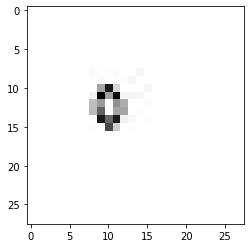

0.25882354
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
im =  np.squeeze(X_train[1])
plt.imshow(im, cmap='Greys')
plt.show()
print(np.max(X_train[1]))
print(Y_train[1])

## MNIST 데이터 로드

In [ ]:
# MNIST 데이터셋 임포트
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11501568/11490434 [==============================] - 0s 0us/step


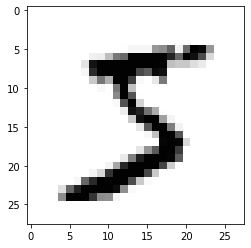

1.0


In [ ]:
im =  np.squeeze(train_images[0])
plt.imshow(im, cmap='Greys')
plt.show()
print(np.max(train_images[0]))

In [ ]:
# 파라미터

BATCH_SIZE = 5 # 배치 크기
ITER = 100
EPOCHS = 30 # 전체 데이터에 대한 훈련 수
VAL_STEPS = 20 # 몇 번에 한번 검증할 건지

## **모델 설정

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import optimizers

In [ ]:
# input_filters : 첫 합성곱 레이어 필터 수
input_filters = [16, 32, 64]

# conv_layers : 사용할 합성곱 레이어(의 필터수) 목록
conv_layers  = [(16, 16), (32,32,), (64,64,)]

# kernal_size : 합성곱 레이어 필터 사이즈
kernal_size = [(3,3), (5, 5)]

# conv_padding: 패딩 적용 여부
conv_padding = ['valid', 'same']

# conv_init : 합성곱 레이어 필터 가중치 초기화 방법
conv_init =  ['glorot_uniform', 'glorot_normal','he_uniform','he_normal']

# dropout_rate : dropout 비율
dropout_rate = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

# pool_window : 풀링 사이즈
pool_window = [(2,2), (3,3)]

# pool_strides : 풀링 스트라이드
pool_strides = [(1,1), (2,2)]

# dense_size : dense 레이어 노드 수
dense_size = [32, 64, 128]

# opt = optimizer
opt = ['SGD', 'Adagrad', 'RMSprop', 'Adam', 'Adamax']

# learning_rate : 학습률
lr = [0.001, 0.01, 0.1, 0.2]

epoch = [5, 15, 30, 40]

batch = [5, 10, 15]

# 하이퍼파라미터 딕셔너리
param_grid = dict(kernal_size=kernal_size, pool_window=pool_window, pool_strides=pool_strides )

In [ ]:
# hyperparameter tuning 대상 정의
def create_model(input_filters=16, conv_layers=(32, 32) , kernal_size=(5,5), conv_padding='valid', conv_init='he_uniform', pool_window=(3,3), pool_strides=(1,1) , dense_size=64, dropout_rate=0.2, lr=0.001):
    model = models.Sequential()
    model.add(layers.Conv2D(input_filters, kernal_size, padding=conv_padding, activation="relu", input_shape=(28, 28, 1), kernel_initializer=conv_init))  
    model.add(layers.Dropout(dropout_rate))
    # dense_layer_sizes 만큼 layer 추가
    for filters in conv_layers:
        model.add(layers.MaxPooling2D(pool_size=pool_window, strides=pool_strides))
        model.add(layers.Conv2D(filters, kernal_size, padding=conv_padding, activation="relu", kernel_initializer=conv_init))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_size, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    opt = tf.optimizers.Adamax(learning_rate=lr)
    model.compile(optimizer = opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=0)
grid_result = grid.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 155, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build

Epoch 1/15
173/173 [==============================] - 1s 4ms/step - loss: 2.3999 - accuracy: 0.1306
Epoch 2/15
173/173 [==============================] - 1s 4ms/step - loss: 1.8842 - accuracy: 0.3780
Epoch 3/15
173/173 [==============================] - 1s 4ms/step - loss: 1.5382 - accuracy: 0.4855
Epoch 4/15
173/173 [==============================] - 1s 4ms/step - loss: 1.3134 - accuracy: 0.5653
Epoch 5/15
173/173 [==============================] - 1s 4ms/step - loss: 1.1538 - accuracy: 0.6301
Epoch 6/15
173/173 [==============================] - 1s 4ms/step - loss: 1.1030 - accuracy: 0.6601
Epoch 7/15
173/173 [==============================] - 1s 4ms/step - loss: 1.0045 - accuracy: 0.6682
Epoch 8/15
173/173 [==============================] - 1s 4ms/step - loss: 0.9309 - accuracy: 0.7098
Epoch 9/15
173/173 [==============================] - 1s 4ms/step - loss: 0.8750 - accuracy: 0.7191
Epoch 10/15
173/173 [==============================] - 1s 4ms/step - loss: 0.8314 - accuracy: 0.7237

In [ ]:
print(grid_result.best_params_)

{'kernal_size': (5, 5), 'pool_strides': (1, 1), 'pool_window': (3, 3)}


In [ ]:
# 다시 실행 XXXXXXXXXXXXXXXXXX
best_params={}

In [ ]:
best_params['conv_layers'] = (32, 32)

In [ ]:
best_params['input_filters'] = 16

In [ ]:
best_params['kernal_size'] = (5,5)

In [ ]:
best_params['conv_padding'] = 'valid'

In [ ]:
best_params['conv_init'] = 'he_uniform'

In [ ]:
best_params['dropout_rate'] = 0.2

In [ ]:
best_params['pool_strides'] = (1,1)
best_params['pool_window'] = (3,3)

In [ ]:
best_params['dense_size'] = 32

In [ ]:
best_params['opt'] = 'Adamax'

In [ ]:
best_params['lr'] = 0.001

In [ ]:
best_params['batch_size'] = 5
best_params['epochs'] = 15

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(64, (5,5), activation="relu", input_shape=(28, 28, 1), kernel_initializer='he_uniform'))  
model2.add(layers.Dropout(0.2))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_uniform'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_uniform'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)        

In [ ]:
opt = tf.optimizers.RMSprop(learning_rate=0.001)
model2.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model2.fit(X_train, Y_train, epochs=30, batch_size=5)

Epoch 1/30
173/173 [==============================] - 2s 5ms/step - loss: 1.7884 - accuracy: 0.4150
Epoch 2/30
173/173 [==============================] - 1s 5ms/step - loss: 1.0799 - accuracy: 0.6694
Epoch 3/30
173/173 [==============================] - 1s 5ms/step - loss: 0.8636 - accuracy: 0.7503
Epoch 4/30
173/173 [==============================] - 1s 5ms/step - loss: 0.6014 - accuracy: 0.8046
Epoch 5/30
173/173 [==============================] - 1s 7ms/step - loss: 0.4669 - accuracy: 0.8694
Epoch 6/30
173/173 [==============================] - 1s 5ms/step - loss: 0.3121 - accuracy: 0.9040
Epoch 7/30
173/173 [==============================] - 1s 5ms/step - loss: 0.2686 - accuracy: 0.9237
Epoch 8/30
173/173 [==============================] - 1s 5ms/step - loss: 0.2027 - accuracy: 0.9318
Epoch 9/30
173/173 [==============================] - 1s 5ms/step - loss: 0.1889 - accuracy: 0.9514
Epoch 10/30
173/173 [==============================] - 1s 5ms/step - loss: 0.1509 - accuracy: 0.9630

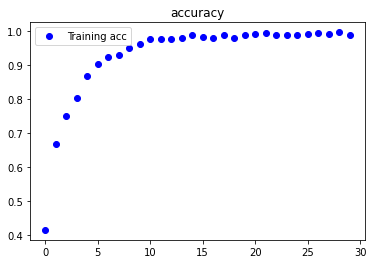

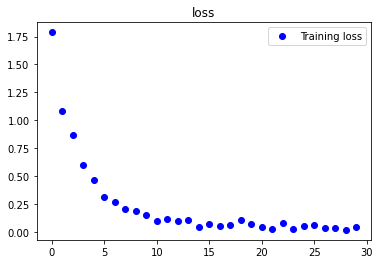

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('loss')
plt.legend()

plt.show()

In [ ]:
model2.fit(train_images, train_labels, epochs=1, batch_size=64)

938/938 [==============================] - 6s 6ms/step - loss: 0.1748 - accuracy: 0.9641


In [ ]:
test_loss, test_acc = model2.evaluate(test_images, test_labels)
test_acc

313/313 [==============================] - 1s 3ms/step - loss: 0.0572 - accuracy: 0.9809


0.98089998960495

In [ ]:
print("-- Evaluate --")
scores = model2.evaluate(X_test, Y_test)
print("%s: %.2f%%" %(model2.metrics_names[1], scores[1]*100))

wrong_predict = []
for i in range(10):
  wrong_predict.append([])


-- Evaluate --
28/28 [==============================] - 0s 4ms/step - loss: 45.2209 - accuracy: 0.8023
accuracy: 80.23%
